In [1]:
# !pip install matplotlib
# !pip install numpy
# !pip install Pillow
# !pip install torch
# !pip install torchvision
# !pip install tqdm
# !pip install wandb
# !pip install albumentations
# !pip install segmentation_models_pytorch
!pip install pytorch-lightning==1.5.4



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from pathlib import Path
import copy
import random
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import albumentations as A

    
dir_img = Path('./dataset/images/')
dir_mask = Path('./dataset/masks/')
path_images = [os.path.join(dir_img, fn) for fn in next(os.walk(dir_img))[2]]
path_masks  = [os.path.join(dir_mask, fn) for fn in next(os.walk(dir_mask))[2]]

# Available images
print('Total images: ',len(path_images))

train_images_filenames = path_images[:80]
val_images_filenames = path_images[80:108]
test_images_filenames = path_images[-20:]
print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))


Total images:  128
80 28 20


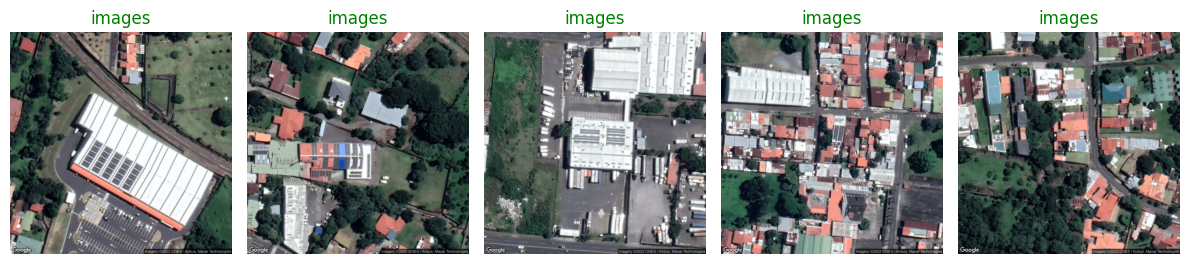

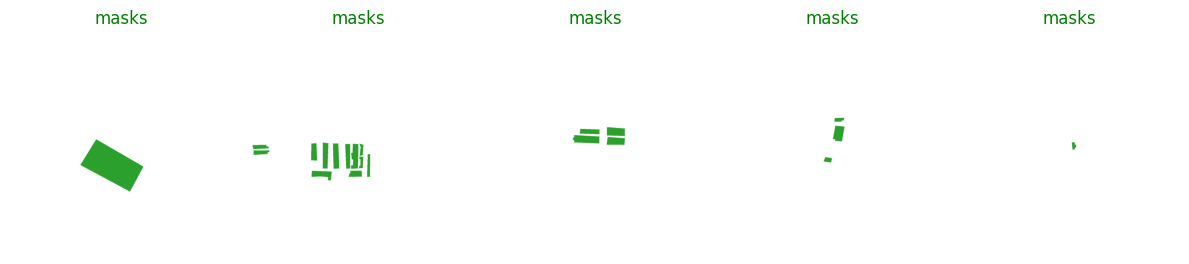

In [4]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(path_images[0:5])
display_image_grid(path_masks[0:5])

c:\Users\carlo\.virtualenvs\Pytorch-UNet-master-C6c1u4_l\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


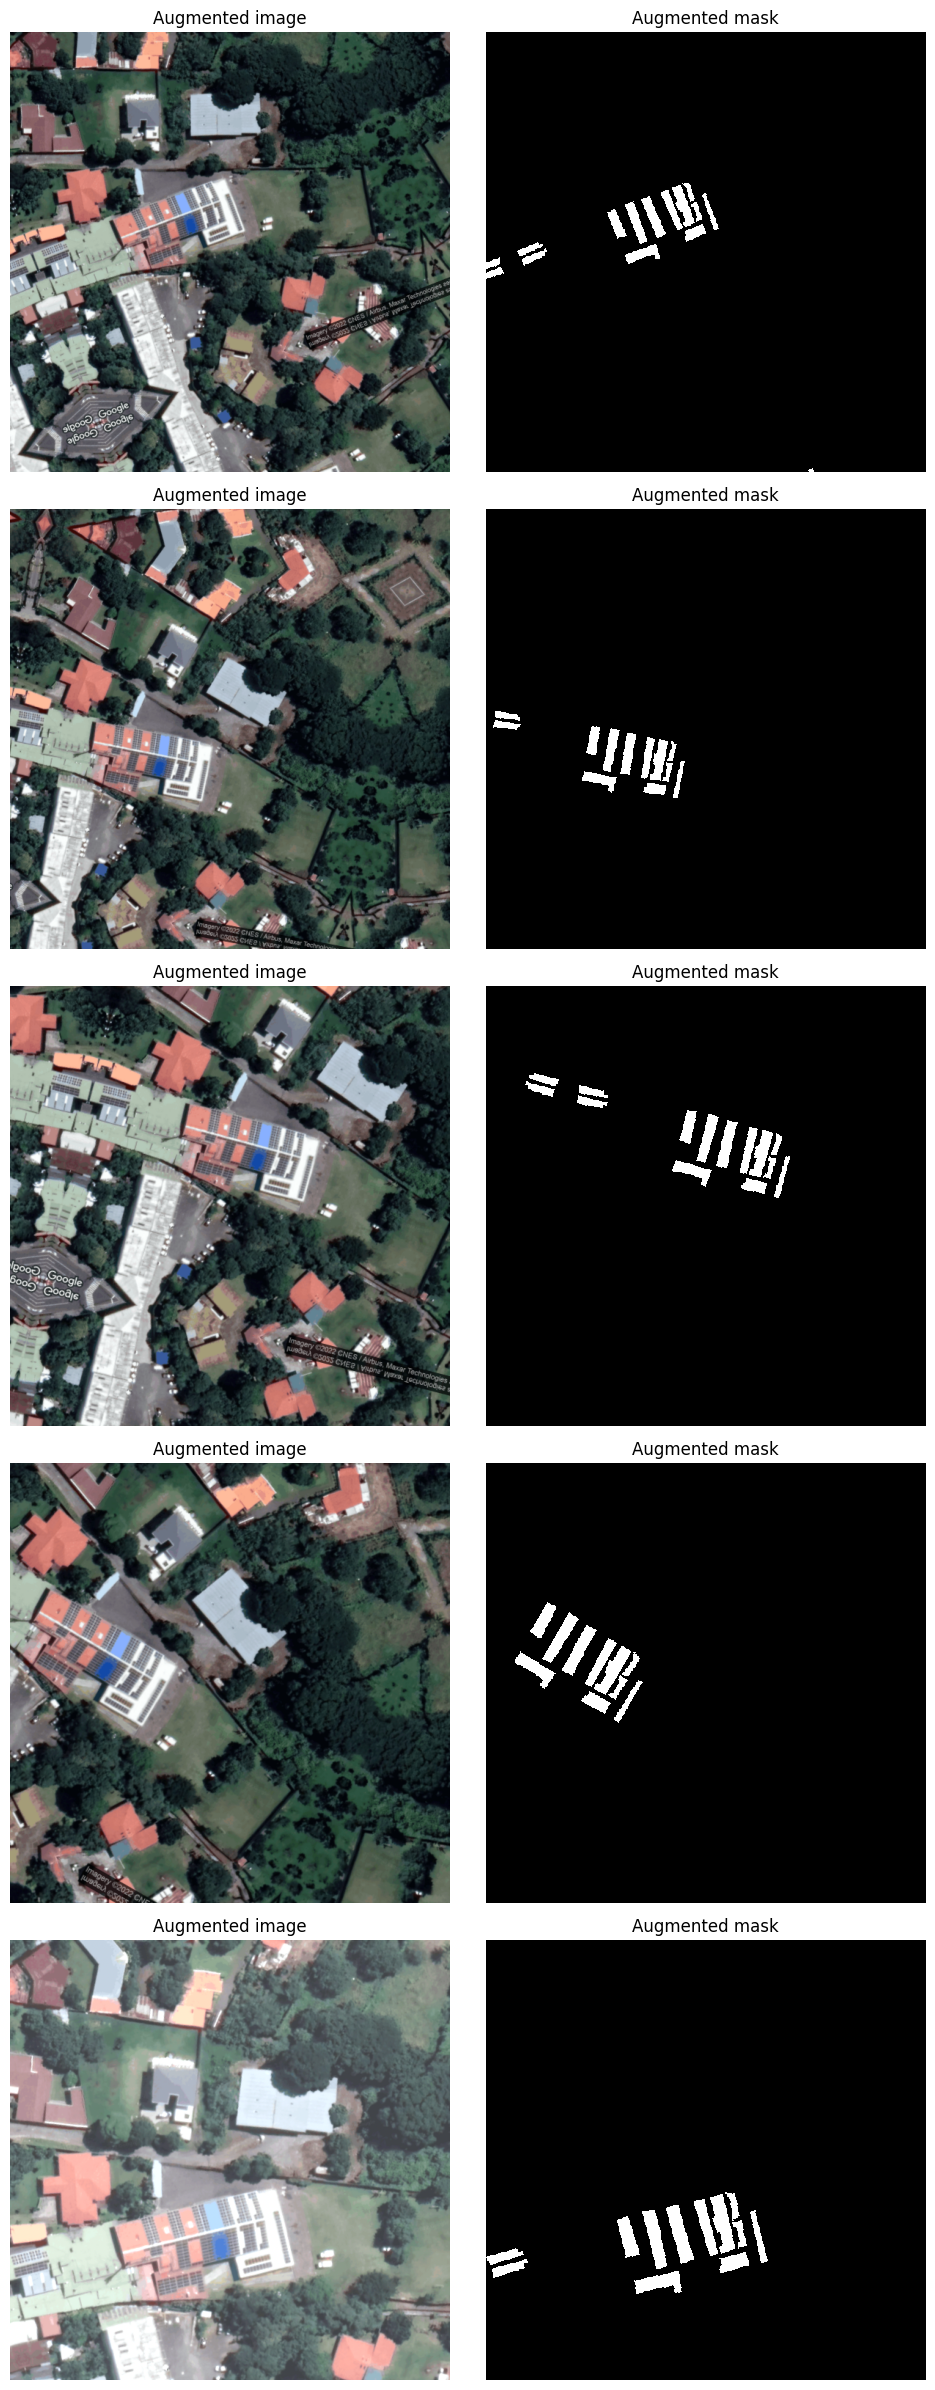

In [5]:
import logging
from os import listdir
from pathlib import Path, WindowsPath

import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torch
from os.path import splitext


'''
Modified from Carvana Dataset.  https://github.com/ysh329/kaggle-carvana-image-masking-challenge/blob/master/Naive%20U-net%20with%20Pytorch.py
'''
class BasicDataset(Dataset):
    def __init__(self, images_filenames: str, images_dir: str, masks_dir: str, scale: float = 1.0, transform = None, mask_suffix: str = ''):
        self.images_filenames = images_filenames
        self.images_dir = Path(images_dir)
        self.masks_dir = Path(masks_dir)
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.scale = scale
        self.mask_suffix = mask_suffix

        self.ids = [splitext(file)[0] for file in images_filenames if not file.startswith('.')]
        if not self.ids:
            raise RuntimeError(f'No input file found in {images_dir}, make sure you put your images there')
        logging.info(f'Creating dataset with {len(self.ids)} examples')
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    @staticmethod
    def loadMask(filename):
        # image = Image.open(filename).convert('RGB')
        # grayImage = image.convert('L')
        # binarizedImage = grayImage.point(lambda x: 1 if x<255 else 0)
        mask = cv2.imread(filename, cv2.IMREAD_UNCHANGED,)
        mask = mask.astype(np.float32)
        mask[mask < 255] = 1
        mask[mask >= 255] = 0
        # binarizedImage.save(filename + "-mask.jpg")
        return mask

    @staticmethod
    def loadIimage(filename):
        image = cv2.imread(filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
 
    def __getitem__(self, idx):
        name = os.path.basename(self.ids[idx])
        img_file = list(self.images_dir.glob(name + '.*'))
        mask_file = list(self.masks_dir.glob(name + self.mask_suffix + '.*'))

        assert len(img_file) == 1, f'Either no image or multiple images found for the ID {name}: {img_file}'
        assert len(mask_file) == 1, f'Either no mask or multiple masks found for the ID {name}: {mask_file}'
        if type(mask_file[0]) == WindowsPath:
            mask = self.loadMask(mask_file[0].__str__())
            img = self.loadIimage(img_file[0].__str__())
        else:
            mask = self.loadMask(mask_file[0])
            img = self.loadIimage(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {name} should be the same size, but are {img.size} and {mask.size}'

        # img = self.preprocess(img, self.scale, is_mask=False)
        # mask = self.preprocess(mask, self.scale, is_mask=True)
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask


class SolarPanelDataset(BasicDataset):
    def __init__(self, images_filenames, images_dir, masks_dir, scale=1, transform = None,  mask_suffix=''):
        super().__init__(images_filenames, images_dir, masks_dir, scale, transform ,  mask_suffix )


train_images_filenames = path_images[:80]
val_images_filenames = path_images[80:108]
test_images_filenames = path_images[-20:]


from albumentations.pytorch import ToTensorV2
# Chosen based on: https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/
train_transform = A.Compose(
    [
        A.Resize(600, 600,3),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

val_transform = A.Compose(
    [ A.Resize(600, 600,3),A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)

train_dataset = SolarPanelDataset(train_images_filenames, dir_img, dir_mask, mask_suffix ='', transform=train_transform)
val_dataset = SolarPanelDataset(val_images_filenames, dir_img, dir_mask, mask_suffix='', transform=val_transform)

from torch.utils.data import DataLoader, random_split

loader_args = dict(batch_size=2, num_workers=4, pin_memory=True)

train_loader = DataLoader(train_dataset, shuffle=True, **loader_args)
val_loader = DataLoader(val_dataset, shuffle=False, drop_last=True, **loader_args)

# https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/
import copy
from operator import itemgetter

def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

print(train_dataset)
visualize_augmentations(train_dataset, idx=1)

In [7]:
import segmentation_models_pytorch as smp
net = smp.Unet(in_channels=3, classes=2, encoder_weights="imagenet",encoder_name="inceptionv4")

In [8]:
!pip install protobuf==3.20.1



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pytorch_lightning as pl

class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [12]:
model = PetModel("FPN", "resnet34", in_channels=3, out_classes=1)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to C:\Users\carlo/.cache\torch\hub\checkpoints\resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:07<00:00, 11.0MB/s]


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device=device)
trainer = pl.Trainer(
    gpus=0, 
    max_epochs=5,
)

trainer.fit(
    model, 
    train_dataloaders=train_loader, 
    val_dataloaders=val_loader,
)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 23.2 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 24736, 23576, 21352, 19652) exited unexpectedly